In [ ]:
!nvidia-smi

Sun Aug  2 17:09:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Bring Dataset

In [ ]:
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1o8j2VFM1F7WLe-xmDyb6iUu8NGA8hjUy' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1o8j2VFM1F7WLe-xmDyb6iUu8NGA8hjUy" -O drone-dataset.zip
# !unzip drone-dataset.zip

In [ ]:
! cp -r  /content/drive/My\ Drive/Drone\ Classification/drone-dataset  /content/

In [2]:
!find . -name ".ipynb_checkpoints"  -delete

In [1]:
import os
data_dir = 'drone-dataset'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['Winged Drones', 'Flying Birds', 'Small QuadCopters', 'Large QuadCopters']


In [2]:
flyingbird_files = os.listdir(data_dir + "/train/Flying Birds")
print('No. of training examples for flying birds:', len(flyingbird_files))
print(flyingbird_files[:5])

largequad_test_files = os.listdir(data_dir + "/test/Large QuadCopters")
print("No. of test examples for large quadcopter:", len(largequad_test_files))
print(largequad_test_files[:5])

No. of training examples for flying birds: 5830
['33543473450_40a952bdc0_b.jpg', 'images523.jpg', '45633617204_f8a5fc0df2_n60.jpg', 'feha_fl_sw.jpg', '8601243770_b96cecd6bf_n.jpg']
No. of test examples for large quadcopter: 141
['i (18)-1.jpg', 'Capture19.jpg', 'Marut-Drones-3.jpg', 'Capture159.jpg', 'i (4).jpg']


## Preprocessing

### Transformatons

In [3]:
import PIL
import torchvision.transforms as T

imagenet_stats = ([0.5270, 0.5794, 0.6113], [0.1725, 0.1665, 0.1815])

train_tfms = T.Compose([
    T.Resize( (224,224), interpolation=PIL.Image.BICUBIC), 
    T.RandomCrop(224, padding=8, padding_mode='reflect'),
    # T.RandomResizedCrop(224, scale=(0.5,0.9), ratio=(1, 1)), 
    # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(),
    # T.RandomVerticalFlip(),
    T.RandomRotation((-30,+30)), 
    T.ToTensor(),
    T.Normalize(*imagenet_stats,inplace=True), 
    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    T.Resize( (224,224), interpolation=PIL.Image.BICUBIC),
    T.ToTensor(), 
    T.Normalize(*imagenet_stats)
])

### Training and Validation Dataset

In [4]:
from dataloader import dataloader
import torch

random_seed = 42
torch.manual_seed(random_seed);

trainset, train_dl = dataloader(data_dir+'/train', transform=train_tfms, batch_size= 256, shuffle = True)
testset,  val_dl  = dataloader(data_dir+'/test',  transform=valid_tfms, batch_size= 256)

In [5]:
img, label = trainset[0]
print(img.shape, label)
print(trainset.classes, len(trainset))
print(testset.classes, len(testset))

torch.Size([3, 224, 224]) 0
['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones'] 11375
['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones'] 4659


### Visualize Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Flying Birds (0)


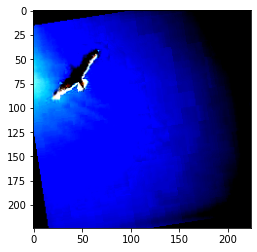

In [6]:
from utils import show_example

show_example( *trainset[0], trainset.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Winged Drones (3)


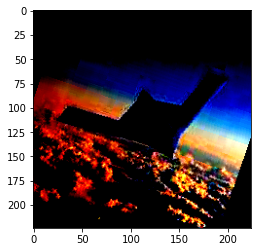

In [7]:
show_example( *trainset[11374], trainset.classes)

### Visualize Sample Batches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


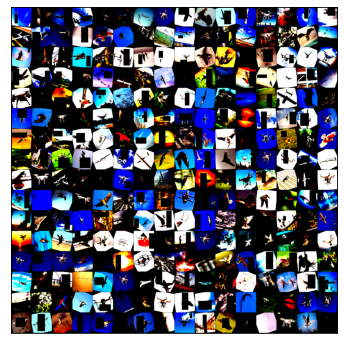

In [8]:
from utils import show_batch

show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


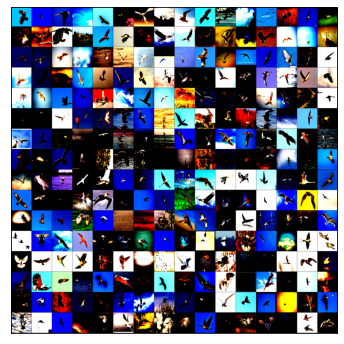

In [9]:
show_batch(val_dl)

## Model - Transfer Learning

In [10]:
from DC_MobilenetV2 import *
model = DroneMobilenetV2()
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


DroneMobilenetV2(
  (network): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias

## Training

In [16]:
from dataloader import *
from train import *

device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model  = to_device(DroneMobilenetV2(), device);
# model.load_state_dict(torch.load('best-epoch.pth'))

cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


### Initial Evaluation

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.466616153717041, 'val_score': 0.16467927396297455}]

### Train newly created Fully Connected layer by freezing other layers

In [ ]:
model.freeze()

In [ ]:
%matplotlib inline

epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

#### 1-10 Epochs

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0088, train_loss: 0.7145, val_loss: 0.3538, val_score: 0.8785



Epoch [1], last_lr: 0.0071, train_loss: 0.3372, val_loss: 0.2715, val_score: 0.9038



Epoch [2], last_lr: 0.0038, train_loss: 0.2801, val_loss: 0.2304, val_score: 0.9151



Epoch [3], last_lr: 0.0005, train_loss: 0.2562, val_loss: 0.2185, val_score: 0.9217



Epoch [4], last_lr: 0.0078, train_loss: 0.2401, val_loss: 0.2228, val_score: 0.9204



Epoch [5], last_lr: 0.0075, train_loss: 0.2348, val_loss: 0.2044, val_score: 0.9266



Epoch [6], last_lr: 0.0042, train_loss: 0.2191, val_loss: 0.1965, val_score: 0.9346



Epoch [7], last_lr: 0.0008, train_loss: 0.1952, val_loss: 0.1862, val_score: 0.9336



Epoch [8], last_lr: 0.0068, train_loss: 0.1881, val_loss: 0.2178, val_score: 0.9190



Epoch [9], last_lr: 0.0079, train_loss: 0.1919, val_loss: 0.1920, val_score: 0.9340
best accuracy = 0.9346137046813965
CPU times: user 1min 30s, sys: 59.1 s, total: 2min 29s
Wall time: 7min 33s


### Un-freeze all layers and continue training

In [ ]:
model.unfreeze()

#### 11-20 Epochs

In [ ]:
%%time
history += fit_one_cycle(10, 0.005, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=1e-5, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0044, train_loss: 0.1738, val_loss: 0.1803, val_score: 0.9377



Epoch [1], last_lr: 0.0036, train_loss: 0.1700, val_loss: 0.1792, val_score: 0.9437



Epoch [2], last_lr: 0.0019, train_loss: 0.1559, val_loss: 0.1778, val_score: 0.9443



Epoch [3], last_lr: 0.0002, train_loss: 0.1438, val_loss: 0.1730, val_score: 0.9451



Epoch [4], last_lr: 0.0039, train_loss: 0.1444, val_loss: 0.1756, val_score: 0.9445



Epoch [5], last_lr: 0.0037, train_loss: 0.1450, val_loss: 0.1866, val_score: 0.9418



Epoch [6], last_lr: 0.0021, train_loss: 0.1408, val_loss: 0.1734, val_score: 0.9474



Epoch [7], last_lr: 0.0004, train_loss: 0.1350, val_loss: 0.1772, val_score: 0.9472



Epoch [8], last_lr: 0.0034, train_loss: 0.1285, val_loss: 0.1765, val_score: 0.9445



Epoch [9], last_lr: 0.0039, train_loss: 0.1312, val_loss: 0.1969, val_score: 0.9451
best accuracy = 0.9473603963851929
CPU times: user 1min 30s, sys: 59.3 s, total: 2min 29s
Wall time: 7min 36s


#### 21-30 Epochs

In [ ]:
%%time
history += fit_one_cycle(10, 0.0005, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=0, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0004, train_loss: 0.1269, val_loss: 0.1729, val_score: 0.9478



Epoch [1], last_lr: 0.0004, train_loss: 0.1242, val_loss: 0.1722, val_score: 0.9476



Epoch [2], last_lr: 0.0002, train_loss: 0.1236, val_loss: 0.1718, val_score: 0.9486



Epoch [3], last_lr: 0.0000, train_loss: 0.1205, val_loss: 0.1719, val_score: 0.9482



Epoch [4], last_lr: 0.0004, train_loss: 0.1226, val_loss: 0.1701, val_score: 0.9494



Epoch [5], last_lr: 0.0004, train_loss: 0.1195, val_loss: 0.1704, val_score: 0.9496



Epoch [6], last_lr: 0.0002, train_loss: 0.1114, val_loss: 0.1706, val_score: 0.9484



Epoch [7], last_lr: 0.0000, train_loss: 0.1159, val_loss: 0.1705, val_score: 0.9494



Epoch [8], last_lr: 0.0003, train_loss: 0.1191, val_loss: 0.1704, val_score: 0.9496



Epoch [9], last_lr: 0.0004, train_loss: 0.1175, val_loss: 0.1712, val_score: 0.9484
best accuracy = 0.9496219158172607
CPU times: user 1min 26s, sys: 58.7 s, total: 2min 25s
Wall time: 7min 27s


#### 31-40 Epochs

In [ ]:
%%time
history += fit_one_cycle(10, 0.0001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=0, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0001, train_loss: 0.1158, val_loss: 0.1703, val_score: 0.9498



Epoch [1], last_lr: 0.0001, train_loss: 0.1184, val_loss: 0.1705, val_score: 0.9486



Epoch [2], last_lr: 0.0000, train_loss: 0.1149, val_loss: 0.1706, val_score: 0.9486



Epoch [3], last_lr: 0.0000, train_loss: 0.1139, val_loss: 0.1713, val_score: 0.9498



Epoch [4], last_lr: 0.0001, train_loss: 0.1131, val_loss: 0.1701, val_score: 0.9496



Epoch [5], last_lr: 0.0001, train_loss: 0.1122, val_loss: 0.1704, val_score: 0.9506



Epoch [6], last_lr: 0.0000, train_loss: 0.1213, val_loss: 0.1704, val_score: 0.9492



Epoch [7], last_lr: 0.0000, train_loss: 0.1126, val_loss: 0.1700, val_score: 0.9500



Epoch [8], last_lr: 0.0001, train_loss: 0.1169, val_loss: 0.1712, val_score: 0.9494



Epoch [9], last_lr: 0.0001, train_loss: 0.1185, val_loss: 0.1705, val_score: 0.9500
best accuracy = 0.9506498575210571
CPU times: user 1min 27s, sys: 58.9 s, total: 2min 26s
Wall time: 7min 32s


## Evaluate The Model

In [15]:
final_accuracy = [evaluate(model, val_dl)]
final_accuracy

[{'val_loss': 0.18293750286102295, 'val_score': 0.9537337422370911}]

## Visualize Plots

### Train Accuracy Plot

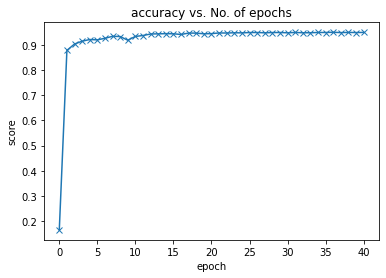

In [ ]:
from utils import plot_scores

plot_scores(history)

### Loss Plot

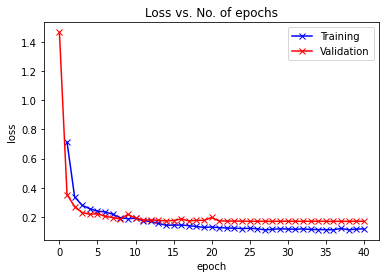

In [ ]:
from utils import plot_losses

plot_losses(history)

### LR Plot

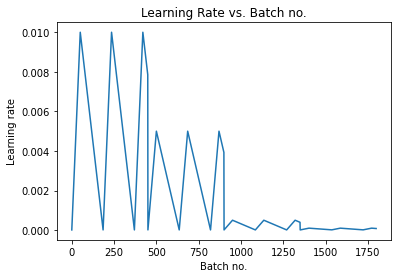

In [ ]:
from utils import plot_lrs

plot_lrs(history)

## Save Model For Deploy

In [ ]:
traced_model = torch.jit.trace(model.cpu(),torch.randn(1,3,224,224))

In [ ]:
traced_model.save('droneMobilenetV2.pt')